In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import json
from pathlib import Path
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, LinearRegression


# Data Extraction

Lets define some usefull functions and global variables we will use later:

In [2]:
def check_or_save_page(filename, url):
    """
        Check if the file exist, if not get the page
        from the url and store in on the disk
        Returns the file content as a soup
    """
    # Check if the page has been stored on disk
    if Path(filename).is_file() is False:
        #print('No page')
        # Get the page
        result = requests.get(url)
        with open(filename,'w') as outfile:
            outfile.write(result.text)
        time.sleep(2)
    #else:
        #print('We got it')
        
    with open(filename) as my_file:
        soup = BeautifulSoup(my_file.read(), "html.parser")
        
    return soup

# Declare global variables
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia']
state_to_iso2 = { 'Alabama': "AL", 'Alaska': "AK", 'Arizona': "AZ", 'Arkansas': "AR", 'California': "CA", 'Colorado': "CO", 'Connecticut': "CT", 'Delaware': "DE", 'Florida': "FL", 'Georgia': "GA", 'Hawaii': "HI", 'Idaho': "ID", 'Illinois': "IL", 'Indiana': "IN", 'Iowa': "IA", 'Kansas': "KS", 'Kentucky': "KY", 'Louisiana': "LA", 'Maine': "ME", 'Maryland': "MD", 'Massachusetts': "MA", 'Michigan': "MI", 'Minnesota': "MN", 'Mississippi': "MS", 'Missouri': "MO", 'Montana': "MT", 'Nebraska': "NE", 'Nevada': "NV", 'New Hampshire': "NH", 'New Jersey': "NJ", 'New Mexico': "NM", 'New York': "NY", 'North Carolina': "NC", 'North Dakota': "ND", 'Ohio': "OH", 'Oklahoma': "OK", 'Oregon': "OR", 'Pennsylvania': "PA", 'Rhode Island': "RI", 'South Carolina': "SC", 'South Dakota': "SD", 'Tennessee': "TN", 'Texas': "TX", 'Utah': "UT", 'Vermont': "VT", 'Virginia': "VA", 'Washington': "WA", 'West Virginia': "WV", 'Wisconsin': "WI", 'Wyoming': "WY", 'District of Columbia': "DC" }

# National unemployement rate by month from 1948 to 2018
# Source: https://data.bls.gov/pdq/SurveyOutputServlet
national_unemployement_rate = pd.read_csv('data/national_unemployement_1948_2018.csv')

# Get the presidental job approval
# Source: https://www.gallup.com
# https://news.gallup.com/interactives/185273/presidential-job-approval-center.aspx
with open('data/all_presidential_job_approval_gallup.json') as f:
    presidential_approval = json.load(f)
presidential_approval = presidential_approval['AllPresidents']['HistoricalPresident']
presidential_approval_df = pd.DataFrame.from_dict([x['PresidentData'] for x in presidential_approval])
print('Presidential approval')
display(presidential_approval_df.head())

print('National unemployement rate')
display(national_unemployement_rate.head())

# List of the US presidents
president_elected_history = pd.read_csv('data/president_elected_history.csv', sep=';')
print('US presidents history')
display(president_elected_history.head())

"""
Get the national level factors
Source: https://en.wikipedia.org/wiki/United_States_presidential_election
"""

# From a tag, extract the number of seats
def extract_seats(tag):
    if tag.findAll('b'):
        d_seats = tag.b.extract().string
    elif tag.sup and tag.sup.decompose():
        d_seats = tag.sup.decompose()
    elif tag.string is None:
        d_seats = tag.text
    else:
        d_seats = tag.string
    return int(d_seats)

def extract_seats_change(tag):
    if tag.sup:
        d_seats_change = tag.text.split('[', 1)[0]
    else:
        d_seats_change = tag.text
    return int(d_seats_change.replace('–', '-'))

# Get the house election years
def extract_house_elections_history():
    house_elections_history = []

    # If the file doesn't exist, get the data from the webpage and store the content to a new file
    filename = 'data/list_of_house_elections_page.html'
    if Path(filename).is_file():
        #with open(filename) as my_file:
        with open(filename, encoding='utf-8') as my_file:
            list_of_house_elections_page = my_file.read()
    else:
        print('no file')
        list_of_house_elections_page = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_House_of_Representatives_elections,_1856%E2%80%93present')
        with open(filename,'w') as outfile:
            outfile.write(list_of_house_elections_page.text)

    soup = BeautifulSoup(list_of_house_elections_page, "html.parser")

    # Find the election years
    data = []
    elections_pages = []
    for t in soup.find_all('a', title=lambda x: x and 'United States House of Representatives elections,' in x):
        if len(t.string) == 4:
            elections_pages.append({
                'year': int(t.string),
                'url':'https://en.wikipedia.org'+t.attrs['href']
            })
            year = int(t.string)+2

            cols = t.parent.parent.find_all('td')

            # Get the number of Democrat seats
            d_seats = extract_seats(cols[1])

            # Get the change in the number of Democrat seats
            d_seats_change = extract_seats_change(cols[2])

            # Get the number of Republican seats
            r_seats = extract_seats(cols[3])
            
            # Get the change in the number of Republican seats
            r_seats_change_by_year = extract_seats_change(cols[4])
            
            #print(1 if year in presidential_years else 0)

            idx = (np.abs(president_elected_history['year'].values-year+1)).argmin()
            president_can_be_re_elected = president_elected_history['can_be_re_elected'].loc[[idx]].values[0]
            president_party = president_elected_history['president_elected_party'].loc[[idx]].values[0]

            # Look for president overall job approval average
            president_name = president_elected_history['president_elected'].loc[[idx]].values[0]
            president_overall_avg_job_approval = presidential_approval_df.loc[presidential_approval_df['PresidentName'] == president_name]['OverallAverage']
            president_overall_avg_job_approval = float(president_overall_avg_job_approval.values[0])/100 if president_overall_avg_job_approval.values.size else None
            
            # Get the national unemployement rate for November
            oct_unemployement_rate = national_unemployement_rate.loc[national_unemployement_rate['Year'] == year]['Oct']
            
            oct_unemployement_rate = oct_unemployement_rate.values[0] if oct_unemployement_rate.values.size else None
            
            data.append({
                'year': year,
                'is_presidential_year': 1 if year in president_elected_history['year'].unique() else 0,
                'president_party': president_party,
                'president_can_be_re_elected': president_can_be_re_elected,
                'president_overall_avg_job_approval': president_overall_avg_job_approval,
                'oct_unemployement_rate': oct_unemployement_rate,
                'last_democrat_seats': d_seats,
                'last_republican seats': r_seats,
                'last_house_majority': 'R' if d_seats < r_seats else 'D'
            })

    return data, elections_pages

data, house_elections_pages = extract_house_elections_history()
data_df = pd.DataFrame(data)
national_level_factors = data_df[[
    'year', 
    'is_presidential_year', 
    'president_party', 
    'president_can_be_re_elected', 
    'president_overall_avg_job_approval', 
    'oct_unemployement_rate',
    'last_democrat_seats', 
    'last_republican seats', 
    'last_house_majority']]
print('National level factors')
display(national_level_factors.sort_values('year', ascending=False).head())

Presidential approval


,DatesinOffice,DaysInOffice,EndDate,FirstTermAverage,JobApprovalHigh,JobApprovalLow,OverallAverage,Party,PresidentName,SecondTermAverage,StartDate
0,2017-Present,658,,-,45.0,35.0,39.5,Rep.,Donald J. Trump,-,2017-01-20
1,2009-2017,2922,2017-01-20,48,67,40,48,Dem.,Barack Obama,47,2009-01-20
2,2001-2009,2922,2009-01-20,62.2,90,25,49.4,Rep.,George W. Bush,36.5,2001-01-20
3,1993-2001,2922,2001-01-20,49.6,73,37,55.1,Dem.,Bill Clinton,60.6,1993-01-20
4,1989-1993,1461,1993-01-20,60.9,89,29,60.9,Rep.,George H. W. Bush,-,1989-01-20


National unemployement rate


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1948,3.4,3.8,4.0,3.9,3.5,3.6,3.6,3.9,3.8,3.7,3.8,4.0
1,1949,4.3,4.7,5.0,5.3,6.1,6.2,6.7,6.8,6.6,7.9,6.4,6.6
2,1950,6.5,6.4,6.3,5.8,5.5,5.4,5.0,4.5,4.4,4.2,4.2,4.3
3,1951,3.7,3.4,3.4,3.1,3.0,3.2,3.1,3.1,3.3,3.5,3.5,3.1
4,1952,3.2,3.1,2.9,2.9,3.0,3.0,3.2,3.4,3.1,3.0,2.8,2.7


US presidents history


,year,president_elected,president_elected_party,can_be_re_elected
0,1824,John Quincy Adams,DR,1
1,1828,Andrew Jackson,D,1
2,1832,Andrew Jackson,D,0
3,1836,Martin Van Buren,D,1
4,1840,William Henry Harrison,W,1


National level factors


,year,is_presidential_year,president_party,president_can_be_re_elected,president_overall_avg_job_approval,oct_unemployement_rate,last_democrat_seats,last_republican seats,last_house_majority
80,2018,0,R,1,0.395,3.7,194,241,R
79,2016,1,R,1,0.395,4.9,188,247,R
78,2014,0,D,0,0.480,5.7,201,234,R
77,2012,1,D,0,0.480,7.8,193,242,R
76,2010,0,D,1,0.480,9.4,257,178,D


# Data Collection - Web Scraping - Data Parsing 

In [3]:
# Get once the necessary pages
presidential_page = requests.get('https://en.wikipedia.org/wiki/United_States_presidential_election')

In [4]:
# List of the US presidents
president_elected_history = pd.read_csv('data/president_elected_history.csv', sep=';')
display(president_elected_history.head())

,year,president_elected,president_elected_party,can_be_re_elected
0,1824,John Quincy Adams,DR,1
1,1828,Andrew Jackson,D,1
2,1832,Andrew Jackson,D,0
3,1836,Martin Van Buren,D,1
4,1840,William Henry Harrison,W,1


## wikipedia.org
### Get the House and Senate election result pages for all the available years

In [7]:
"""
Get the district level factor
"""
def get_district_list():
    district_list = []
    url = 'https://en.wikipedia.org/wiki/United_States_House_of_Representatives_elections,_2016'
    filename = 'data/wikipedia/all_state_districts_list_page.html'
    
    # Check if the page has been stored on disk
    soup = check_or_save_page(filename, url)
    
    # Find the districts page links
    districts = soup.find_all('a', href=re.compile(r'(.*\/wiki\/.* )|(.*_congressional_district)'))
    
    for district in districts:
        if any(substring in district.string for substring in states) \
        and district.string not in district_list \
        and "'s" not in district.string \
        and "12th" not in district.string \
        and '1st' not in district.string:
            district_state = ''
            # Get the corresponding state
            for state in states:
                if state in district.string:
                    district_state = state
            
            # Format the district name
            if 'at-large' in district.string:
                dist_name = 'At-Large'
            else:
                # Find the district number
                dist_number = [int(s) for s in district.string.split() if s.isdigit()]
                if len(dist_number) > 0:
                    dist_number = dist_number[0]
                    dist_name = 'District {}'.format(dist_number)
                else:
                    continue
                
            #print(district_state, dist_name)
            
            district_list.append({
                'name': dist_name,
                'page_url': 'https://en.wikipedia.org{}'.format(district['href']),
                'state': district_state
            })
            
    # Remove duplicate in the list
    district_list = [dict(t) for t in {tuple(d.items()) for d in district_list}]
    
    return district_list

def get_wiki_district_pages(districts):
    # Get the district pages if they have not been stored on disk yet
    for district in districts:
        filename = 'data/district_pages/{}.html'.format(district['name'])

        # Check if the page has been stored on disk
        check_or_save_page(filename, district['page_url'])
        
def parse_district_house_results(filename, district, state):
    undesirable_chars = ['\*', '%', '\(incumbent\)', '\(inc.\)', '\(write-in\)']
    district_house_results = []
    with open(filename) as my_file:
        soup = BeautifulSoup(my_file.read(), "html.parser")
        
        # Find the election results tables
        caption = soup.find_all('caption')
        elems = []
        for capt in caption:
            x = capt.get_text()
            if ('United States House of Representatives elections,' in x or
                'congressional district election' in x or
                'US House election, ' in x or
                'Congressional District House Election'
            ):
                elems.append(capt)

        for capt in elems:
            # Find the date
            match = re.match(r'.*([1-2][0-9]{3})', capt.text)
            if match is None:
                continue

            # Then it found a match!
            year = int(match.group(1))
            #print(year)

            # Get the result table itself
            table = capt.find_parent('table')
            table_body = table.find('tbody')
            rows = table_body.find_all('tr')

            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                cols = [ele for ele in cols if ele] # Get rid of empty values

                if len(cols) and cols[0] in ['Republican', 'Democratic']:
                    print(cols)
                    
                    percent = np.NaN
                    if len(cols) > 3 and cols[3] != 'N/A':
                        percent = float(re.sub("|".join(undesirable_chars), "", cols[3]))/100
                    
                    votes = np.NaN
                    if len(cols) > 2 and cols[2] == 'N/A':
                        votes = np.NaN
                    elif len(cols) > 2 and '%' not in cols[2] and cols[2] != '100.00':
                        votes = int(cols[2].replace(',', '').replace('.', ''))
                    elif len(cols) > 2 and ('%' in cols[2] or cols[2] == '100.00'):
                        percent = float(re.sub("|".join(undesirable_chars), "", cols[2]))/100
                    
                    district_house_results.append({
                        'year': year,
                        'candidate_party': 'R' if cols[0] == "Republican" else 'D',
                        'candidate_name': re.sub("|".join(undesirable_chars), "", cols[1]),
                        'votes': votes,
                        'percent': percent
                    })
                    
    return pd.DataFrame(district_house_results)
    
def get_district_level_factors(district):
    state = districts_df.loc[districts_df['name'] == district]['state'].values[0]
    dist_level_factors = []
    # Get the page of the district
    html_filename = 'data/district_pages/{}.html'.format(district)
    json_filename = 'data/district_pages/{}.json'.format(district)
    
    # If there is no already formated data, get them from the corresponding Wikipedia page
    if Path(json_filename).is_file() is False:
        district_house_results = parse_district_house_results(html_filename, district, state)
        display(district_house_results)
    else:
        print('get from json')
        district_house_results = pd.read_json(json_filename)
        display(district_house_results)
        
    # Now, for each year
    for year in district_house_results['year'].unique():
        # If there is more than 1 candidate this year
        # Get the current year
        if len(district_house_results.loc[district_house_results['year'] == year]) > 1:
            curr_year_idx = district_house_results.loc[district_house_results['year'] == year]['votes'].idxmax()
            curr_year = district_house_results.loc[[curr_year_idx]]
        else:
            curr_year = district_house_results        
        
        # Get previous year
        prev_year = district_house_results.loc[district_house_results['year'] == year-2]

        if prev_year.empty is False:
            # If there is more than 1 candidate the previous year
            if len(prev_year) > 1:
                prev_year_winner_idx = prev_year['votes'].idxmax()
                prev_year_winner = prev_year.loc[[prev_year_winner_idx]]
            else:
                prev_year_winner = prev_year

            # Get the incumbent name
            incumbent = prev_year_winner['candidate_name'].values[0]

            # Get the elections previously won by the incumbent
            incumbent_history = district_house_results.loc[
                (district_house_results['candidate_name'] == incumbent) &
                (district_house_results['year'] < year)
            ]

            incubent_first_elected_idx = incumbent_history['year'].idxmin()
            incubent_first_elected = incumbent_history.loc[[incubent_first_elected_idx]]['year'].values[0]
            incubent_is_candidate = curr_year.loc[curr_year['candidate_name'] == incumbent].empty

            dist_data = {
                'year': year,
                'state': state,
                'district': district,
                'incumbent': incumbent,
                'incumbent_party': 'R' if prev_year_winner['candidate_party'].values[0] == "Republican" else 'D',
                'incumbent_count_victories': len(incumbent_history),
                'incumbent_first_elected': incubent_first_elected,
                'incumbent_running_re_election': 0 if incubent_is_candidate else 1,
                'candidate_elected_party': curr_year['candidate_party'].values[0]
            }

            dist_level_factors.append(dist_data)
        else:
            print('yop')
            dist_data = {
                'year': year,
                'state': state,
                'district': district,
                'incumbent': np.NaN,
                'incumbent_party': np.NaN,
                'incumbent_count_victories': np.NaN,
                'incumbent_first_elected': np.NaN,
                'incumbent_running_re_election': np.NaN,
                'candidate_elected_party': curr_year['candidate_party'].values[0]
            }
            dist_level_factors.append(dist_data)

    return dist_level_factors

#for district in ['Alabama 1', 'Alabama 2']:
#for district in ['Arkansas 1']:
#    district_level_factors = get_district_level_factors(district)
#    display(pd.DataFrame(district_level_factors).sort_values('year', ascending=True))
#    #display(district_level_factors)

def get_wiki_districts_house_results(districts_list):
    candidate_results = []
    wiki_undesirable_chars = [
        '\*', '%', '\(Incumbent\)', '\(incumbent\)', '\(inc.\)', '\(write-in\)', 
        '\(as a write-in\)'
    ]
    for district in districts_list:
        # To remove
        if district['state'] != 'Wisconsin' or district['name'] != 'District 2':
        #if district['state'] != 'Wyoming':
            continue
        
        print('Will get results for house/{}/{}.html'.format(district['state'], district['name']))
        print('Source: {}'.format(district['page_url']))
        
        # In some cases, the wikipedia page is too messy to crawl
        # So I manually gather the informations into a json file
        # If this file exist, it will be prefered
        json_filename = 'data/wikipedia/house/{}/{}.json'.format(district['state'], district['name'])
        if Path(json_filename).is_file() is True:
            print('Data are store in a formated JSON')
            continue
        
        # Create the directories if necessary
        if not os.path.exists('data/wikipedia/house'):
            os.makedirs('data/wikipedia/house')
        if not os.path.exists('data/wikipedia/house/{}'.format(district['state'])):
            os.makedirs('data/wikipedia/house/{}'.format(district['state']))
            
        filename = 'data/wikipedia/house/{}/{}.html'.format(district['state'], district['name'])
        
        # Check if the page has been stored on disk
        soup = check_or_save_page(filename, district['page_url'])
        
        # Find the results tables
        caption = soup.find_all('caption')
        tables = []
        for capt in caption:
            x = capt.get_text()
            if ('United States House of Representatives elections,' in x or
                'congressional district election' in x or
                'US House election, ' in x or
                'Congressional District House Election'
            ):
                # print(capt)
                table = capt.find_parent('table')
                tables.append(table)
        
        # For each result table, extract the results
        for table in tables:
            # Get the year
            table_title = table.find('caption')
            
            # If this is a table about a special election, skip it
            if 'Special' in table_title.text:
                continue
            
            year_match = re.match(r'.*([1-2][0-9]{3})', table_title.text)
            
            # If there is no year match, then this table isn't of interest
            if year_match is None:
                continue
            
            year = int(year_match.group(1))
            # To remove
            if year != 2018:
                continue
            # print(year)
            
            # Get the result table itself
            rows = table.find('tbody').find_all('tr')
            candidate_rows = []
            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                # If all the values of the cols are empty strings, continue
                if all(v is '' for v in cols):
                    continue
                    
                # print(cols)
                
                # If this row contains a candidate results
                if len(cols) > 2 and cols[1] in ['Republican', 'Democratic']:
                    # print(cols)
                    
                    party = 'R' if cols[1] == 'Republican' else 'D'
                    name = cols[2]
                    votes = int(cols[3].replace(',', '').replace('[8]', '').replace('c', '').replace('.', '').replace(' ', '')) if cols[3] != '' else np.NaN
                    percent = float(cols[4].replace('%', '')) if cols[4] != '' else np.NaN
                    
                    candidate_rows.append({
                        'year': year,
                        'state': district['state'],
                        'district': district['name'],
                        'is_incumbent': np.NaN,
                        'name': name,
                        'party': party,
                        'percent': percent,
                        'votes': votes,
                        'won': 0
                    })
                    
            # If we found no candidate data, continue
            if len(candidate_rows) == 0:
                continue
            
            # Enrich the candidates data
            max_percent = max([x['percent'] for x in candidate_rows])
            for candidate in candidate_rows:
                # Check if the candidate won the elections
                if candidate['percent'] == max_percent:
                    candidate['won'] = 1
                    
                # Check if we can determine if the candidate is an incumbent
                if '(inc.)' in candidate['name'] or '(incumbent)' in candidate['name'] or '(Incumbent)' in candidate['name']:
                    candidate['is_incumbent'] = 1

                # Clean the candidate name
                candidate['name'] = re.sub("|".join(wiki_undesirable_chars), "", candidate['name'])
                    
                candidate_results.append(candidate)
                
            # If we found that one of the candidates is an incumbent, the others are sets to 0
            max_incumbent = max([x['is_incumbent'] for x in candidate_rows])
            #print(type(max_incumbent))
            if max_incumbent == 1:
                for candidate in candidate_rows:
                    candidate['is_incumbent'] = 0 if candidate['is_incumbent'] != 1 else 1

    return candidate_results

districts_list = get_district_list()
# districts_df = pd.DataFrame(districts_list)
# display(districts_df.loc[districts_df['state'] == 'Wyoming'])

wiki_house_history = get_wiki_districts_house_results(districts_list)
# Store in disk
wiki_house_history_df = pd.DataFrame(wiki_house_history)
display(wiki_house_history_df)
# wiki_house_history_df.to_csv('data/wikipedia/house_results.csv', encoding='utf-8')

Will get results for house/Wisconsin/District 2.html
Source: https://en.wikipedia.org/wiki/Wisconsin%27s_2nd_congressional_district


""


**We now have on disk ALL the available historical district results from Wikipedia**

Lets take a look:

In [603]:
test_df = pd.read_csv('data/wikipedia/house_results.csv', index_col=0)
display(test_df.head())

,district,is_incumbent,name,party,percent,state,votes,won,year
0,District 19,NaN,Randy Neugebauer,R,85.0,Texas,160136.0,1,2012
1,District 19,NaN,Randy Neugebauer,R,78.0,Texas,106059.0,1,2010
2,District 19,NaN,Andy Wilson,D,19.0,Texas,25984.0,0,2010
3,District 19,NaN,Randy Neugebauer,R,72.0,Texas,168501.0,1,2008
4,District 19,NaN,Dwight Fullingim,D,25.0,Texas,58030.0,0,2008


## ballotpedia.org

So far so good but the 2018 results are missing on Wikipedia and the available data are not always exhaustives. So I decided to get the same informations from a different source: Ballotpedia.  
Here we have the complete 2018 results as well as historical date from 2012.  
Note that the incumbent information is consistent.  

### Get the House and Senate election result pages for all the available years

In [ ]:
def get_house_senate_state_list():
    house_state_list = []
    senate_state_list = []
    filename = 'data/ballotpedia/house_state_list_src.html'
    url = 'https://ballotpedia.org/U.S._House_battlegrounds,_2018'
    
    # Check if the page has been stored on disk
    soup = check_or_save_page(filename, url)
    
    # Find the list of the U.S. Senate Elections by State (2018) pages
    table = soup.find('table', { 'class': 'infobox' })
    for link in table.find_all('a', href=lambda x: x and '/United_States_Senate_election_in_' in x):
        senate_state_list.append({
            'state': link.text,
            'url': 'https://ballotpedia.org{}'.format(link['href'])
        })

    # Find the list of the U.S. House Elections by State (2018) pages
    table = soup.find('table', { 'class': 'infobox' })
    for link in table.find_all('a', href=lambda x: x and (
        '/United_States_House_of_Representatives_election_in_' in x or
        '/United_States_House_of_Representatives_elections_in_' in x
    )):
        house_state_list.append({
            'state': link.text,
            'url': 'https://ballotpedia.org{}'.format(link['href'])
        })

    return house_state_list, senate_state_list

def get_district_pages(dict_page_url, year, state, district):
    """ 
        Recursively get all available previous election result pages
        for a given district
    """
    print('Will get house/{}/{}/{}.html'.format(state, district, year))
    # Create the directories if necessary
    if not os.path.exists('data/ballotpedia/house/'):
        os.makedirs('data/ballotpedia/house/')
    if not os.path.exists('data/ballotpedia/house/{}'.format(state)):
        os.makedirs('data/ballotpedia/house/{}'.format(state))
    if not os.path.exists('data/ballotpedia/house/{}/{}'.format(state, district)):
        os.makedirs('data/ballotpedia/house/{}/{}'.format(state, district))
    
    filename = 'data/ballotpedia/house/{}/{}/{}.html'.format(state, district, year)
    dict_soup = check_or_save_page(filename, dict_page_url)
    
    # Check if there is a link to a previous electoral year for this state
    table = dict_soup.find('table', { 'class': 'infobox' })
    div = table.find('div', style=lambda x: x and '#A3B1BF' in x and 'float:left;' in x)
            
    # If there is one
    if div is not None:
        # Extract the link election year
        prev_year = int(re.match(r'.*([1-2][0-9]{3})', div.text).group(1))
        
        if prev_year < year:                
            # Get the link to this disctict House election results parge
            link = div.find('a')
            #print(link['href'])

            # Get this page
            url = 'https://ballotpedia.org{}'.format(link['href'])
            get_district_pages(url, prev_year, state, district)

def get_house_senate_state_districts_list(house_state_list):
    start_year = 2018
    state_district_list = []
    for house_state in house_state_list:
        # To remove
        #if house_state['state'] != 'Maryland':
        #    continue

        filename = 'data/ballotpedia/2018_house_{}.html'.format(house_state['state'])
        
        # Check if the page has been stored on disk
        soup = check_or_save_page(filename, house_state['url'])
        #print(soup)
        
        # Get the district page links
        table = soup.find('table', { 'class': 'infobox' })
        
        links = table.find_all('a', href=lambda x: x and (
            '_Congressional_District_election,_' in x
        ))
        
        if len(links) == 0:
            title = soup.find('b', text=lambda x : x and 'District Pages' in x)
            links = title.parent.parent.find_all('a', href=lambda x: x and (
                '_Congressional_District_election,_' in x
            ))

        for link in links:
            print(link.text)
            url = 'https://ballotpedia.org{}'.format(link['href'])
            state_district_list.append({
                'state': house_state['state'],
                'district': link.text
            })
            #print(' |-', url)

            # Get the page
            get_district_pages(url, start_year, house_state['state'], link.text)
            
    return state_district_list

house_state_list, senate_state_list = get_house_senate_state_list()
state_district_list = get_house_senate_state_districts_list(house_state_list)

### Extract the House election results for every districts and years

In [584]:
def extract_district_data(state_district_list):
    results = []
    undesirable_chars = ['\*', '%', 'Incumbent', '\(D\)', '\(R\)']
    for item in state_district_list:
        # To remove
        #if item['state'] != 'New Hampshire' or item['district'] != 'District 2':
        #if item['state'] != 'Wyoming':
        #    continue

        # Get the pages
        directory = 'data/ballotpedia/house/{}/{}'.format(item['state'], item['district'])
        files = [f for f in listdir(directory) if isfile(join(directory, f))]
        
        # For each year, get the district data
        for file in files:
            # Extract the year
            year = int(re.match(r'.*([1-2][0-9]{3})', file).group(1))
            candidate_rows = []
            
            # To remove
            #if year != 2018:
            #    continue
            
            # Get the page content
            filename = 'data/ballotpedia/house/{}/{}/{}'.format(item['state'], item['district'], file)
            with open(filename) as my_file:
                soup = BeautifulSoup(my_file.read(), "html.parser")
            
            # The 2018 pages requires a different approach
            if year == 2018:
                #print(2018)
                # Find the result table
                table = soup.find('table',  { 'class': 'results_table' })
                rows = table.find_all('tr')
                
                for row in rows:
                    cols = row.find_all('td')
                    cols = [ele.text.strip() for ele in cols]
                    cols = [ele for ele in cols if ele] # Get rid of empty values
                    
                    # Check if is incumbant
                    incumbent = 1 if row.find('b') and row.find('b').find('u') else 0
                    #print(cols)
                    if len(cols) == 4 and cols[0] == '✔':
                        is_winner = 1
                        name = cols[1] +' Incumbent' if incumbent == 1 else cols[1]
                        percent = cols[2] if len(cols) > 1 else np.NaN
                        votes = cols[3] if len(cols) > 2 else np.NaN
                        party = 'Democratic' if '(D)' in cols[1] else 'Republican'
                        candidate_rows.append([party, name, percent, votes, is_winner])
                        
                    elif len(cols) == 3 and '(D)' in cols[0] or '(R)' in cols[0]:
                        is_winner = 0
                        name = cols[0] +' Incumbent' if incumbent == 1 else cols[0]
                        percent = cols[1] if len(cols) > 1 else np.NaN
                        
                        votes = cols[2] if len(cols) > 2 else np.NaN
                        if len(cols) > 1:
                            party = 'Democratic' if '(D)' in cols[0] else 'Republican'
                        else:
                            party = np.NaN
                            
                        candidate_rows.append([party, name, percent, votes, is_winner])
                
            else:            
                # Find the result table
                th = soup.find('th', colspan='5', style=lambda x: x and 'background-color:#444' in x)
                table = th.find_parent('table')
                #table_body = table.find('tbody')
                rows = table.find_all('tr')
                #print(rows)

                for row in rows:
                    cols = row.find_all('td')
                    cols = [ele.text.strip() for ele in cols]
                    cols = [ele for ele in cols if ele] # Get rid of empty values

                    # Ignore the rows not about the candidates
                    if 'Republican' not in cols and not 'Democratic' in cols:
                        continue

                    # Check if the candidate won the elections
                    is_winner = 1 if row.find('a', title="Won") else 0
                    cols.append(is_winner)
                    candidate_rows.append(cols)
                    
            # If there was only one candidate
            if len(candidate_rows) == 1:
                if type(candidate_rows[0][3]) is int:
                    candidate_rows[0].append(candidate_rows[0][3])
                    candidate_rows[0][3] = np.NaN

            for candidate in candidate_rows:
                #print(year, item['district'], candidate)
                
                # Get and format the candidate party
                candidate_party = 'R' if candidate[0] == 'Republican' else 'D'
                
                # Get and clean the candidate name
                candidate_name = re.sub("|".join(undesirable_chars), "", candidate[1]).rstrip()
                
                # Get and clean the candidate percent
                if type(candidate[2]) is str:
                    candidate_percent = float(candidate[2].replace('%', ''))
                else:
                    candidate_percent = candidate[2]
                
                # Get and clean the candidate vote
                if type(candidate[3]) is str:
                    candidate_vote = int(candidate[3].replace(',', ''))
                else:
                    candidate_vote = candidate[3]
                
                # Determine whether or not the candidate is incumbent
                candidate_is_incumbent = 1 if 'Incumbent' in candidate[1] else 0
                
                results.append({
                    'year': year,
                    'state': item['state'],
                    'district': item['district'] if item['district'] != 'General election' else 'At-Large',
                    'name': candidate_name,
                    'party': candidate_party,
                    'percent': candidate_percent,
                    'votes': candidate_vote,
                    'is_incumbent': candidate_is_incumbent,
                    'won': candidate[4]
                })
                
                #print(results)
                #print('')

        #soup = BeautifulSoup(my_file.read(), "html.parser")
        #print(soup)
    return results

ballo_house_history = extract_district_data(state_district_list)

# Store on disk
ballo_house_history_df = pd.DataFrame(ballo_house_history)
ballo_house_history_df.to_csv('data/ballotpedia/ballo_results.csv', encoding='utf-8')

## Merge the data from wikipedia.org and  ballotpedia.org

Now we have two dataset with the same columns and some overlaping data. Its time to merge them.  
It appears that the data from ballotpedia.org are more consistent so we will favor them.

In [9]:
ballo_df = pd.read_csv('data/ballotpedia/ballo_results.csv', index_col=0)
wikipedia_df = pd.read_csv('data/wikipedia/house_results.csv', index_col=0)

merged_df =  pd.concat([wikipedia_df.loc[wikipedia_df['year'] < 2012], ballo_df])
display(merged_df.head())

,district,is_incumbent,name,party,percent,state,votes,won,year
1,District 19,NaN,Randy Neugebauer,R,78.0,Texas,106059.0,1,2010
2,District 19,NaN,Andy Wilson,D,19.0,Texas,25984.0,0,2010
3,District 19,NaN,Randy Neugebauer,R,72.0,Texas,168501.0,1,2008
4,District 19,NaN,Dwight Fullingim,D,25.0,Texas,58030.0,0,2008
5,District 19,NaN,Randy Neugebauer,R,68.0,Texas,92811.0,1,2006


## Impute and derive from the data

From this data, we can create new predictors: 

- Impute the missing data for `is_incumbent`
- First time the incumbent has been elected
- Number of incumbents victories

In [10]:
derived_df = merged_df.copy()
derived_df = derived_df.sort_values(by=['year'])

# Number of NaN values for the `is_incumbent` col
print('NaN is_incumbent values before:', derived_df['is_incumbent'].isna().sum())

def check_if_is_incumbent(row):
    is_incumbent = row['is_incumbent']

    # Check if there is a previous election for this state, district and candidate
    prev_year = row['year'] - 2
    prev_year_row = derived_df.loc[(derived_df['state'] == row['state']) & (derived_df['district'] == row['district']) & (derived_df['name'] == row['name']) & (derived_df['year'] == prev_year)]

    # If the row has NaN for the col `is_incumbent` and the candidate won the last election
    if np.isnan(row['is_incumbent']) and prev_year_row.empty is False and prev_year_row['won'].values[0] == 1:
        is_incumbent = 1
    # If the candidate lose the last elections, it is likely he isn't the incumbent
    elif np.isnan(row['is_incumbent']) and prev_year_row.empty is False and prev_year_row['won'].values[0] == 0:
        is_incumbent
    # If the candidate didn't participate to the last election, 
    # we can safely assume he isn't the incumbent
    elif np.isnan(row['is_incumbent']) and prev_year_row.empty:
        is_incumbent = 0
        
    return is_incumbent

# Check if the candidate has already been elected the past year (and so is an incumbent)
derived_df['is_incumbent'] = derived_df.apply(check_if_is_incumbent, axis=1)

print('NaN is_incumbent values after:', derived_df['is_incumbent'].isna().sum())

NaN is_incumbent values before: 2748
NaN is_incumbent values after: 118


We gain the `is_incumbent` information for 2630 rows. 118 remains NaN.  
Now, we will add a new column to know the year of the first election the candidate won:

In [11]:
def get_first_year_elected(row):
    first_elected = np.NaN
    # Get the first year the candidate has been elected (if exist)
    victories = derived_df.loc[(derived_df['state'] == row['state']) & (derived_df['district'] == row['district']) & (derived_df['name'] == row['name']) & (derived_df['won'] == 1)]

    if victories.empty is False:
        first_elected = victories['year'].min()
        
    return first_elected

derived_df['first_time_elected'] = derived_df.apply(get_first_year_elected, axis=1)

Finally, we want to count the number of victories of each candidate:

In [12]:
def count_victories(row):
    count_victories = 0
    victories = derived_df.loc[(derived_df['state'] == row['state']) & (derived_df['district'] == row['district']) & (derived_df['name'] == row['name']) & (derived_df['won'] == 1)]
    
    if victories.empty is False:
        count_victories = len(victories)
    
    return count_victories
    
derived_df['count_victories'] = derived_df.apply(count_victories, axis=1)

In [13]:
display(derived_df.head())

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories
1963,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,1,1824,1824.0,7
1964,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,1,1826,1824.0,7
1965,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,1,1828,1824.0,7
1967,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,2
1966,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,1,1830,1824.0,7


## Additional factors

Let's also add the **unemployement rate** at the district level when available, else, at the national level.

In [14]:
def get_district_number(row):
    district = row['district']
    
    p = re.compile("District (.*) \(")
    dist = p.search(row['district']).group(1)
    
    if dist == '(at Large)':
        district = 'At-Large'
    else:
        district = 'District {}'.format(dist)
    
    return district

def get_state_dist_unemployement(row):
    unemployement_rate = np.NaN
    
    # Find the corresponding unemployement rate
    unemp_row = unemp_df.loc[(unemp_df['state'] == row['state']) & \
                             (unemp_df['district'] == row['district']) & \
                             (unemp_df['year'] == row['year'])]

    if unemp_row.empty is False:
        unemployement_rate = unemp_row['unemp_rate_16'].values[0]
    else:
        # Use the national unemployement rate of October instead
        nat_oct_unemployement_rate = national_unemployement_rate.loc[national_unemployement_rate['Year'] == row['year']]['Oct']
        unemployement_rate = np.NaN if nat_oct_unemployement_rate.empty else nat_oct_unemployement_rate.values[0]
        
    return unemployement_rate

augmented_df = derived_df.copy()

unemp_df = pd.read_csv('data/unemployment/unemp_2012_2017.csv',sep=';')
unemp_df['state'] = unemp_df['state'].str.rsplit(',').str[-1].str.strip()
unemp_df['district'] = unemp_df.apply(get_district_number, axis=1)

augmented_df['unemployement_rate'] = augmented_df.apply(get_state_dist_unemployement, axis=1)

display(augmented_df.loc[augmented_df['state'] == 'Alabama'].head())

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate
889,District 1,0.0,Judy Belk,D,38.0,Alabama,67507.0,0,2002,NaN,0,5.7
888,District 1,0.0,Jo Bonner,R,61.0,Alabama,108102.0,1,2002,2002.0,6,5.7
1223,District 4,0.0,Robert B. Aderholt,R,87.0,Alabama,139705.0,1,2002,2002.0,5,5.7
8075,District 7,0.0,Artur Davis,D,92.3,Alabama,153735.0,1,2002,2002.0,4,5.7
4929,District 5,0.0,Bud Cramer,D,73.0,Alabama,143029.0,1,2002,2002.0,3,5.7


We will also add the following national level factors:  

- is_presidential_year: 1 if Yes, 0 if No
- president_can_be_re_elected: Can the president stand for re-election ? 1 = Yes, 0 = No  
- president_party: D or R
- president_overall_avg_job_approval: Only available from 1953 to 2018
- last_D_house_seats: # of Democrat seats at the last elections
- last_R_house_seats: # of Republican seats at the last elections
- last_house_majority: Which party had the majority at the last House elections. D or R

In [18]:
nat_augmented_df = augmented_df.copy()

def add_is_presidential_year(row):
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'is_presidential_year']
    
    if df.empty is False:
        result = df.values[0]
    
    return result

def add_president_can_be_re_elected(row):
    # idx = (np.abs(president_elected_history['year'].values-row['year']+1)).argmin()
    # return president_elected_history['can_be_re_elected'].loc[[idx]].values[0]
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'president_can_be_re_elected']
    
    if df.empty is False:
        result = df.values[0]
    
    return result

def add_president_party(row):
    # idx = (np.abs(president_elected_history['year'].values-row['year']+1)).argmin()
    # return president_elected_history['president_elected_party'].loc[[idx]].values[0]
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'president_party']
    
    if df.empty is False:
        result = df.values[0]
    
    return result

def add_president_overall_avg_job_approval(row):
    # idx = (np.abs(president_elected_history['year'].values-row['year']+1)).argmin()
    # president_name = president_elected_history['president_elected'].loc[[idx]].values[0]
    # president_overall_avg_job_approval = presidential_approval_df.loc[presidential_approval_df['PresidentName'] == president_name]['OverallAverage']
    # return float(president_overall_avg_job_approval.values[0])/100 if president_overall_avg_job_approval.values.size else np.NaN
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'president_overall_avg_job_approval']
    
    if df.empty is False:
        result = df.values[0]
    
    return result

def add_last_D_house_seats(row):
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'last_democrat_seats']
    
    if df.empty is False:
        result = df.values[0]
    
    return result
    
def add_last_R_house_seats(row):
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'last_republican seats']
    
    if df.empty is False:
        result = df.values[0]
    
    return result

def add_last_house_majority(row):
    result = np.NaN
    df = national_level_factors.loc[national_level_factors['year'] == row['year'], 'last_house_majority']
    
    if df.empty is False:
        result = df.values[0]
    
    return result

# is_presidential_year
nat_augmented_df['is_presidential_year'] = nat_augmented_df.apply(add_is_presidential_year, axis=1)

# president_can_be_re_elected
nat_augmented_df['president_can_be_re_elected'] = nat_augmented_df.apply(add_president_can_be_re_elected, axis=1)

# president_party
nat_augmented_df['president_party'] = nat_augmented_df.apply(add_president_party, axis=1)

# president_overall_avg_job_approval
nat_augmented_df['president_overall_avg_job_approval'] = nat_augmented_df.apply(add_president_overall_avg_job_approval, axis=1)

# last_D_house_seats
nat_augmented_df['last_D_house_seats'] = nat_augmented_df.apply(add_last_D_house_seats, axis=1)

# last_R_house_seats
nat_augmented_df['last_R_house_seats'] = nat_augmented_df.apply(add_last_R_house_seats, axis=1)

# last_house_majority
nat_augmented_df['last_house_majority'] = nat_augmented_df.apply(add_last_house_majority, axis=1)


In [19]:
display(nat_augmented_df.loc[nat_augmented_df['year'] == 1958].head())
#display(nat_augmented_df.head())

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority
5838,District 15,1.0,Joe M. Kilgore,D,100.00,Texas,28404.0,1,1958,1956.0,4,6.7,0.0,0.0,R,0.65,232.0,203.0,D
3347,District 19,0.0,Roy E. Reynolds,R,24.70,California,26092.0,0,1958,NaN,0,6.7,0.0,0.0,R,0.65,232.0,203.0,D
2080,District 1,1.0,Ray J. Madden,D,66.40,Indiana,95801.0,1,1958,1942.0,17,6.7,0.0,0.0,R,0.65,232.0,203.0,D
6868,District 4,1.0,Wayne Aspinall,D,63.61,Colorado,43785.0,1,1958,1950.0,11,6.7,0.0,0.0,R,0.65,232.0,203.0,D
1319,District 17,1.0,Cecil R. King,D,75.30,California,182965.0,1,1958,1942.0,13,6.7,0.0,0.0,R,0.65,232.0,203.0,D


Finally, we add the fundraising data we got on followthemoney.org (from 2009 to 2018). 
The candidate names are not formated the same way as our data from wikipedia and ballotpedia so we will use a fuzzy search algorithm to match them.

In [42]:
# You need to install the fuzzywuzzy package
# Source: https://github.com/seatgeek/fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

fundraising_df = pd.read_csv('data/Fundraising/followthemoney_2009-2018.csv')
# display(fundraising_df.head())

def add_fundraising(row):
    fundraising = np.NaN
    
    if row['year'] > 1991:
        # Get the code ISO 2 of the state
        iso2 = state_to_iso2[row['state']]
        # Find the corresponding rows for this year and state from the fundraising data
        fundraising_rows = fundraising_df.loc[(fundraising_df['Election_Year'] == row['year']) &\
                          (fundraising_df['Election_Jurisdiction'] == iso2)]
        # Try to match with the candidate name
        for index, line in fundraising_rows.iterrows():
            # Get the district number
            district_numb = int([int(s) for s in line['Office_Sought'].split() if s.isdigit()][0])
            
            if 'District {}'.format(district_numb) != row['district']:
                continue
            
            ratio = fuzz.token_sort_ratio(row['name'], line['Candidate'].lower())

            if ratio > 79:
                fundraising = line['Total_$']
    
    return fundraising

nat_augmented_df['fundraising'] =  nat_augmented_df.apply(add_fundraising, axis=1)

In [47]:
display(nat_augmented_df.loc[nat_augmented_df['year'] > 2017].head())

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
357,District 28,1.0,Adam Schiff,D,76.4,California,127153.0,1,2018,2012.0,4,3.7,0.0,1.0,R,0.395,194.0,241.0,R,4606209.66
3003,District 2,0.0,Shireen Ghorbani,D,38.4,Utah,84011.0,0,2018,NaN,0,3.7,0.0,1.0,R,0.395,194.0,241.0,R,109604.65
380,District 31,1.0,Pete Aguilar,D,56.1,California,61747.0,1,2018,2014.0,3,3.7,0.0,1.0,R,0.395,194.0,241.0,R,2046673.91
2979,District 35,1.0,Lloyd Doggett,D,71.2,Texas,137325.0,1,2018,2012.0,4,3.7,0.0,1.0,R,0.395,194.0,241.0,R,543906.56
2986,District 36,1.0,Brian Babin,R,72.6,Texas,160592.0,1,2018,2014.0,3,3.7,0.0,1.0,R,0.395,194.0,241.0,R,891968.14


# Store the final dataset on disk

In [49]:
nat_augmented_df.to_csv('data/ready_to_use_dataset.csv', index=False)

# Manually fix errors and add some missing results by hand

In some edge-cases, the crawler didn't do a good job or the data was particularly messy, resulting in more than 1 winner for an election, 0 winner or duplicate candidates. Here, we fix have to manually check every of this occurences and fix them.

In [50]:
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df.loc[(house_df['year'] == 1858) & \
             (house_df['state'] == 'Indiana') & \
             (house_df['district'] == 'District 1') &\
             (house_df['party'] == 'D'), 'won'] = 1

house_df.loc[(house_df['year'] == 1876) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 4') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 1878) & \
             (house_df['state'] == 'Indiana') & \
             (house_df['district'] == 'District 1') &\
             (house_df['party'] == 'D'), 'won'] = 0

house_df.loc[(house_df['year'] == 1876) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 4') &\
             (house_df['party'] == 'D'), 'won'] = 0

house_df.loc[(house_df['year'] == 1888) & \
             (house_df['state'] == 'Indiana') & \
             (house_df['district'] == 'District 1') &\
             (house_df['party'] == 'R'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1930) & \
             (house_df['state'] == 'Utah') & \
             (house_df['district'] == 'District 2') &\
             (house_df['percent'] == 44.13)].index)
house_df = house_df.drop(house_df.loc[(house_df['year'] == 1930) & \
             (house_df['state'] == 'Utah') & \
             (house_df['district'] == 'District 2') &\
             (house_df['percent'] == 42.34)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1940) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 3') &\
             (house_df['name'] == 'William E. Burney')].index)
house_df = house_df.drop(house_df.loc[(house_df['year'] == 1940) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 3') &\
             (house_df['name'] == 'Henry Leonard')].index)

house_df.loc[(house_df['year'] == 1956) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 3') &\
             (house_df['party'] == 'D'), 'won'] = 0

house_df.loc[(house_df['year'] == 1958) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 3') &\
             (house_df['party'] == 'D'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1966) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 14') &\
             (house_df['percent'] != 56.4) &\
             (house_df['percent'] != 43.6)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1970) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 24') &\
             (house_df['percent'] != 65.1) &\
             (house_df['percent'] != 32.4)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1970) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 35') &\
             (house_df['percent'] != 67.0) &\
             (house_df['percent'] != 30.3)].index)

house_df = house_df.append({'district': 'District 6', 'is_incumbent': 0.0, 'name': 'Rick Nolan', \
                           'party': 'D', 'percent': np.NaN, 'state': 'Minnesota', 'votes': 109955, \
                           'won': 1, 'year': 1972, 'first_time_elected': np.NaN, 'count_victories': 0,\
                           'unemployement_rate': 5.6, 'is_presidential_year': 1.0, \
                           'president_can_be_re_elected': 0.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.49, 'last_D_house_seats': 255.0,\
                           'last_R_house_seats': 180.0, 'last_house_majority': 'D', 'fundraising': np.NaN},\
                          ignore_index=True)
house_df.loc[(house_df['year'] == 1972) & \
             (house_df['state'] == 'Minnesota') & \
             (house_df['district'] == 'District 6') &\
             (house_df['name'] == 'John M. Zwach {incumbent}'), 'is_incumbent'] = 1.0
house_df.loc[(house_df['year'] == 1972) & \
             (house_df['state'] == 'Minnesota') & \
             (house_df['district'] == 'District 6') &\
             (house_df['name'] == 'John M. Zwach {incumbent}'), 'name'] = 'John M. Zwach'

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1974) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 13') &\
             (house_df['percent'] != 52.6) &\
             (house_df['percent'] != 42.4)].index)

house_df = house_df.append({'district': 'District 6', 'is_incumbent': 1.0, 'name': 'Rick Nolan', \
                           'party': 'D', 'percent': 55.4, 'state': 'Minnesota', 'votes': 96465, \
                           'won': 1, 'year': 1974, 'first_time_elected': 1972, 'count_victories': 1,\
                           'unemployement_rate': 6.0, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 0.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.49, 'last_D_house_seats': 243.0,\
                           'last_R_house_seats': 192.0, 'last_house_majority': 'D', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 6', 'is_incumbent': 1.0, 'name': 'Rick Nolan', \
                           'party': 'D', 'percent': 59.6, 'state': 'Minnesota', 'votes': 147507, \
                           'won': 1, 'year': 1976, 'first_time_elected': 1972, 'count_victories': 2,\
                           'unemployement_rate': 7.7, 'is_presidential_year': 1.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'D', \
                           'president_overall_avg_job_approval': 0.455, 'last_D_house_seats': 291.0,\
                           'last_R_house_seats': 144.0, 'last_house_majority': 'D', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df.loc[(house_df['year'] == 1978) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 3') &\
             (house_df['party'] == 'R'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1982) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 30') &\
             (house_df['percent'] != 53.9) &\
             (house_df['percent'] != 46.1)].index)

house_df = house_df.append({'district': 'District 6', 'is_incumbent': 1.0, 'name': 'Gerry Sikorski', \
                           'party': 'D', 'percent': np.NaN, 'state': 'Minnesota', 'votes': 154603, \
                           'won': 1, 'year': 1984, 'first_time_elected': 1982, 'count_victories': 1,\
                           'unemployement_rate': 7.4, 'is_presidential_year': 1.0, \
                           'president_can_be_re_elected': 0.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.528, 'last_D_house_seats': 269.0,\
                           'last_R_house_seats': 166.0, 'last_house_majority': 'D', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1986) & \
             (house_df['state'] == 'Hawaii') & \
             (house_df['district'] == 'District 1') &\
             (house_df['percent'] != 59.20) &\
             (house_df['percent'] != 37.45)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1990) & \
             (house_df['state'] == 'Hawaii') & \
             (house_df['district'] == 'District 2') &\
             (house_df['percent'] != 66.27) &\
             (house_df['percent'] != 30.64)].index)

house_df.loc[(house_df['year'] == 1994) & \
             (house_df['state'] == 'Connecticut') & \
             (house_df['district'] == 'District 2') &\
             (house_df['party'] == 'R'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1996) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 5') &\
             (house_df['percent'] != 71.94) &\
             (house_df['percent'] != 28.06)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1996) & \
             (house_df['state'] == 'Oregon') & \
             (house_df['district'] == 'District 3') &\
             (house_df['percent'] != 66.93) &\
             (house_df['percent'] != 26.32)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 1998) & \
             (house_df['state'] == 'New Mexico') & \
             (house_df['district'] == 'District 1') &\
             (house_df['percent'] != 48.44) &\
             (house_df['percent'] != 41.88)].index)

house_df.loc[(house_df['year'] == 2002) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 7') &\
             (house_df['party'] == 'D'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2002) & \
             (house_df['state'] == 'Hawaii') & \
             (house_df['district'] == 'District 2') &\
             (house_df['percent'] != 56.16) &\
             (house_df['percent'] != 39.98)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2006) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 50') &\
             (house_df['percent'] != 53.2) &\
             (house_df['percent'] != 43.5)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2006) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 5') &\
             (house_df['percent'] != 59.62) &\
             (house_df['percent'] != 40.35)].index)

house_df.loc[(house_df['year'] == 2006) & \
             (house_df['state'] == 'Connecticut') & \
             (house_df['district'] == 'District 2') &\
             (house_df['party'] == 'R'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2006) & \
             (house_df['state'] == 'Louisiana') & \
             (house_df['district'] == 'District 2') &\
             (house_df['percent'] != 56.55) &\
             (house_df['percent'] != 43.45)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2006) & \
             (house_df['state'] == 'Mississippi') & \
             (house_df['district'] == 'District 4') &\
             (house_df['percent'] != 79.79) &\
             (house_df['percent'] != 20.21)].index)

house_df.loc[(house_df['year'] == 2006) & \
             (house_df['state'] == 'Pennsylvania') & \
             (house_df['district'] == 'District 8') &\
             (house_df['party'] == 'R'), 'won'] = 0

house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'Alabama') & \
             (house_df['district'] == 'District 2') &\
             (house_df['party'] == 'R'), 'won'] = 0

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 12') &\
             (house_df['percent'] != 75.2) &\
             (house_df['percent'] != 18.5)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 5') &\
             (house_df['percent'] != 60.0) &\
             (house_df['percent'] != 37.0)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'Colorado') & \
             (house_df['district'] == 'District 6') &\
             (house_df['percent'] != 61.0) &\
             (house_df['percent'] != 39.0)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'Maryland') & \
             (house_df['district'] == 'District 4') &\
             (house_df['percent'] != 85.83) &\
             (house_df['percent'] != 12.85)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'Massachusetts') & \
             (house_df['district'] == 'District 1') &\
             (house_df['name'] == 'Robert Feuer')].index)
house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'Massachusetts') & \
             (house_df['district'] == 'District 1') &\
             (house_df['party'] == 'D'), 'won'] = 1

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'New Mexico') & \
             (house_df['district'] == 'District 1') &\
             (house_df['percent'] != 55.65) &\
             (house_df['percent'] != 44.35)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2008) & \
             (house_df['state'] == 'New Mexico') & \
             (house_df['district'] == 'District 3') &\
             (house_df['percent'] != 56.74) &\
             (house_df['percent'] != 30.47)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2010) & \
             (house_df['state'] == 'Alabama') & \
             (house_df['district'] == 'District 5') &\
             (house_df['percent'] != 58.0) &\
             (house_df['percent'] != 42.0)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2010) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 42') &\
             (house_df['percent'] != 62.0) &\
             (house_df['percent'] != 32.0)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2010) & \
             (house_df['state'] == 'Hawaii') & \
             (house_df['district'] == 'District 1') &\
             (house_df['percent'] != 53.23) &\
             (house_df['percent'] != 46.77)].index)

house_df = house_df.drop(house_df.loc[(house_df['year'] == 2010) & \
             (house_df['state'] == 'Texas') & \
             (house_df['district'] == 'District 14') &\
             (house_df['percent'] != 76.0) &\
             (house_df['percent'] != 24.0)].index)

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Arkansas') & \
             (house_df['district'] == 'District 4') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 10') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 39') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'California') & \
             (house_df['district'] == 'District 45') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Florida') & \
             (house_df['district'] == 'District 8') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Georgia') & \
             (house_df['district'] == 'District 4') &\
             (house_df['party'] == 'D'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Georgia') & \
             (house_df['district'] == 'District 7') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Maine') & \
             (house_df['district'] == 'District 2') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Minnesota') & \
             (house_df['district'] == 'District 1') &\
             (house_df['party'] == 'R'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'New Hampshire') & \
             (house_df['district'] == 'District 2') &\
             (house_df['name'] == 'Steve Negron'), 'party'] = 'R'

house_df = house_df.append({'district': 'District 2', 'is_incumbent': 1.0, 'name': 'Annie Kuster', \
                           'party': 'D', 'percent': np.NaN, 'state': 'New Hampshire', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2012, 'count_victories': 3,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'New Jersey') & \
             (house_df['district'] == 'District 3') &\
             (house_df['name'] == 'Tom MacArthur'), 'party'] = 'R'
house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'New Jersey') & \
             (house_df['district'] == 'District 3') &\
             (house_df['name'] == 'Tom MacArthur'), 'percent'] = 48.8
house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'New Jersey') & \
             (house_df['district'] == 'District 3') &\
             (house_df['name'] == 'Tom MacArthur'), 'votes'] = 147036
house_df = house_df.append({'district': 'District 3', 'is_incumbent': 0.0, 'name': 'Andrew Kim', \
                           'party': 'D', 'percent': 49.9, 'state': 'New Jersey', 'votes': 150510, \
                           'won': 1, 'year': 2018, 'first_time_elected': np.NaN, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'New York') & \
             (house_df['district'] == 'District 22') &\
             (house_df['party'] == 'D'), 'won'] = 1

house_df.loc[(house_df['year'] == 2018) & \
             (house_df['state'] == 'Utah') & \
             (house_df['district'] == 'District 4') &\
             (house_df['party'] == 'D'), 'won'] = 1

house_df = house_df.append({'district': 'District 2', 'is_incumbent': 1.0, 'name': 'Mark Pocan', \
                           'party': 'D', 'percent': 97.5, 'state': 'Wisconsin', 'votes': 239573, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2012, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 7', 'is_incumbent': 1.0, 'name': 'Terri Sewell', \
                           'party': 'D', 'percent': 100, 'state': 'Alabama', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2010, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 5', 'is_incumbent': 1.0, 'name': 'John Lewis', \
                           'party': 'D', 'percent': 100, 'state': 'Georgia', 'votes': 275061, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2002, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 24', 'is_incumbent': 1.0, 'name': 'Frederica S. Wilson', \
                           'party': 'D', 'percent': 100, 'state': 'Florida', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2012, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 21', 'is_incumbent': 1.0, 'name': 'Lois Frankel', \
                           'party': 'D', 'percent': 100, 'state': 'Florida', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2016, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 14', 'is_incumbent': 1.0, 'name': 'Kathy Castor', \
                           'party': 'D', 'percent': 100, 'state': 'Florida', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2010, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 10', 'is_incumbent': 1.0, 'name': 'Val Demings', \
                           'party': 'D', 'percent': 100, 'state': 'Florida', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2016, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 4', 'is_incumbent': 1.0, 'name': 'Joseph Kennedy III', \
                           'party': 'D', 'percent': 100, 'state': 'Massachusetts', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2012, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 1', 'is_incumbent': 1.0, 'name': 'Richard Neal', \
                           'party': 'D', 'percent': 100, 'state': 'Massachusetts', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2012, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 8', 'is_incumbent': 1.0, 'name': 'Stephen Lynch', \
                           'party': 'D', 'percent': 100, 'state': 'Massachusetts', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2012, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df = house_df.append({'district': 'District 7', 'is_incumbent': 0.0, 'name': 'Ayanna Pressley', \
                           'party': 'D', 'percent': 100, 'state': 'Massachusetts', 'votes': np.NaN, \
                           'won': 1, 'year': 2018, 'first_time_elected': 2018, 'count_victories': 0,\
                           'unemployement_rate': 3.7, 'is_presidential_year': 0.0, \
                           'president_can_be_re_elected': 1.0, 'president_party': 'R', \
                           'president_overall_avg_job_approval': 0.395, 'last_D_house_seats': 194.0,\
                           'last_R_house_seats': 241.0, 'last_house_majority': 'R', 'fundraising': np.NaN},\
                          ignore_index=True)

house_df.to_csv('data/ready_to_use_dataset.csv', index=False)

After refelecting on the dataset, we decided that the count_victories variable should only count the number of victories of the candidate _to date_ rather than the overall (past and future) number of victories.

In [51]:
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
def get_count_victories(row):
    count_victories = 0
    # Try to find previous years in this state and district where this candidate won
    previous_won = house_df.loc[(house_df['name'] == row['name']) & \
                                (house_df['won'] == 1) & \
                                (house_df['state'] == row['state']) & \
                                (house_df['district'] == row['district']) & \
                                (house_df['year'] < row['year'])]
    
    if len(previous_won):
        count_victories = len(previous_won)
        
    return count_victories
    
house_df['count_victories'] = house_df.apply(get_count_victories, axis=1)

In [52]:
house_df.to_csv('data/ready_to_use_dataset.csv', index=False)

# Dataset preparation

In [49]:
#house_df = pd.read_csv('data/ready_to_use_dataset.csv')

years = house_df['year'].unique()

for year in [2018]:
    print(year)
    grouped_df = house_df.loc[house_df['year'] == year].groupby(['state', 'district']).first().reset_index(drop=False)
    dist_count = 0
    for state in house_df.loc[house_df['year'] == year, 'state'].unique():
        dist_list = house_df.loc[(house_df['state'] == state), 'district'].unique()
        n_dist = len(dist_list)
        dist_count = dist_count + n_dist

        for dist in dist_list:
            check = grouped_df.loc[(grouped_df['state'] == state) & (grouped_df['district'] == dist)]
            if len(check) == 0:
                print(state, dist)

    print(dist_count)

2018
435


With the cleaned raw data at hand, we can now format them in a way that will facilitate the analysis:

In [ ]:
house_df = pd.read_csv('data/ready_to_use_dataset.csv')

# Get the list of distinct years

for year in house_df['year'].unique():
    for state in house_df['state'].unique():
        for district in house_df.loc[house_df['state'] == state, 'district'].unique():
            rows = house_df.loc[(house_df['year'] == year) & (house_df['state'] == state) & \
                         (house_df['district'] == district)]
            if (len(rows) > 2):
                print(year, state, district, len(rows))

# Data Imputation - NaN values

## some data summary information

In [4]:
#Get the data extracted from different sources
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)

(9974, 20)

In [5]:
#check for datatypes
display(house_df.dtypes)

district                               object
is_incumbent                          float64
name                                   object
party                                  object
percent                               float64
state                                  object
votes                                 float64
won                                     int64
year                                    int64
first_time_elected                    float64
count_victories                         int64
unemployement_rate                    float64
is_presidential_year                  float64
president_can_be_re_elected           float64
president_party                        object
president_overall_avg_job_approval    float64
last_D_house_seats                    float64
last_R_house_seats                    float64
last_house_majority                    object
fundraising                           float64
dtype: object

In [6]:
display(house_df.head())

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,1,1824,1824.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,1,1826,1824.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,1,1828,1824.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,1,1830,1824.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#get columns with NaN data
house_df.isna().sum()

district                                 0
is_incumbent                           112
name                                     0
party                                    0
percent                                 15
state                                    0
votes                                   67
won                                      0
year                                     0
first_time_elected                    4445
count_victories                          0
unemployement_rate                     979
is_presidential_year                   102
president_can_be_re_elected            102
president_party                        102
president_overall_avg_job_approval    1060
last_D_house_seats                     102
last_R_house_seats                     102
last_house_majority                    102
fundraising                           7172
dtype: int64

In [8]:
#data normalisation
def normalise_df(df, mins, maxs):
    df = (df - mins)/(maxs - mins)
    return df

In [6]:
#get rid of NaNs
def clean_nan(data,i_type='mean'):
    #cleans NaNs
    #data: dataframe
    #i_type: if mean -> mean imputation only
    #           if model -> model imputation for undraising and president_overall_avg_job_approval
    
    #delete duplicates
    data = data.drop_duplicates(['year', 'state', 'district', 'name'])
    
    #needed just in case if not all NaNs are imputed with aggregated mean for fundraising below
    mean_fund = data.fundraising.mean()
    
    #groups needed for imputation
    gr_dist = data.groupby(['state', 'district'])
    gr_year = data.groupby(['state', 'district','year'])
    
    #imputation of values
    if i_type == 'mean':
        data['president_overall_avg_job_approval'].fillna(gr_dist['president_overall_avg_job_approval'].transform('mean'), inplace=True)
        data['fundraising'].fillna(gr_dist['fundraising'].transform('mean'), inplace=True)
        data['fundraising'].fillna(mean_fund, inplace=True) #necessary if in first fundraising imputation NaNs remain
    else:
        model_df = clean_nan_model(data)
        data['fundraising'] = model_df.fundraising
        data['president_overall_avg_job_approval']=model_df.president_overall_avg_job_approval
    data['votes'].fillna(gr_dist['votes'].transform('mean'), inplace=True)
    data['last_D_house_seats'].fillna(gr_dist['last_D_house_seats'].transform('mean'), inplace=True)
    data['last_R_house_seats'].fillna(gr_dist['last_R_house_seats'].transform('mean'), inplace=True)
    data['percent'].fillna(100 - gr_year['percent'].transform('sum'), inplace=True)
    data['unemployement_rate'].fillna(gr_dist['unemployement_rate'].transform('mean'), inplace=True)
    data['is_presidential_year'].fillna(0, inplace=True)
    data['president_can_be_re_elected'].fillna(1, inplace=True)
    data['president_party'].fillna(0, inplace=True)
    s = gr_year['is_incumbent'].transform("sum")
    r=[]
    for index, item in enumerate(s):
        if s[item] > 0:
            r.append(0)
        else:
            r.append(1)
    r = pd.Series(r)
    data['is_incumbent'].fillna(r, inplace=True)
    data['last_house_majority'].fillna(gr_dist['last_house_majority'].transform(lambda x: x.value_counts().index[0]), inplace=True)
    data.loc[data['first_time_elected'].isna() & (data['won']==1),'first_time_elected'] = data.year
    data.loc[data['first_time_elected'].isna() & (data['won']==0),'first_time_elected'] = 0

    return data

In [ ]:
#clean orignal dataset nan_df with mean only
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df_mean = clean_nan(house_df,i_type='mean')

In [12]:
#test if imputation worked well
house_df_mean.isna().sum()

district                              0
is_incumbent                          0
name                                  0
party                                 0
percent                               0
state                                 0
votes                                 0
won                                   0
year                                  0
first_time_elected                    0
count_victories                       0
unemployement_rate                    0
is_presidential_year                  0
president_can_be_re_elected           0
president_party                       0
president_overall_avg_job_approval    0
last_D_house_seats                    0
last_R_house_seats                    0
last_house_majority                   0
fundraising                           0
dtype: int64

In [ ]:
#model based imputation
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df_model = clean_nan(house_df, i_type='model')

In [14]:
#test if model based imputation worked
house_df_model.isna().sum()

district                              0
is_incumbent                          0
name                                  0
party                                 0
percent                               0
state                                 0
votes                                 0
won                                   0
year                                  0
first_time_elected                    0
count_victories                       0
unemployement_rate                    0
is_presidential_year                  0
president_can_be_re_elected           0
president_party                       0
president_overall_avg_job_approval    0
last_D_house_seats                    0
last_R_house_seats                    0
last_house_majority                   0
fundraising                           0
dtype: int64

In [ ]:
#save model and mean imputed data to csv
house_df_mean.to_csv('data/house_mean_imputation.csv', index=False)
house_df_model.to_csv('data/house_model_imputation.csv', index=False)

# Baseline Model

In [31]:
#further modeling for baseline with mean imputed data
house_df = house_df_mean.copy()

In [32]:
print(len(house_df))

9974


In [33]:
#check that we always have one (and only one) winner per district
house_df_grouped=house_df.groupby(['year', 'state', 'district'])['won'].sum().reset_index(drop=False)
house_df_grouped[house_df_grouped['won']!=1]

,year,state,district,won


In [34]:
#show that we have to remove first_time_elected if it's in the future, compared to current observation
house_df[(house_df['year']-house_df['first_time_elected']<=0)&(house_df['name']=='John Law')]

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
21,District 1,0.0,John Law,D,55.7,Indiana,13476.0,1,1860,1860.0,0,5.790196,1.0,1.0,R,0.525667,98.000000,116.000000,R,552917.8375


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


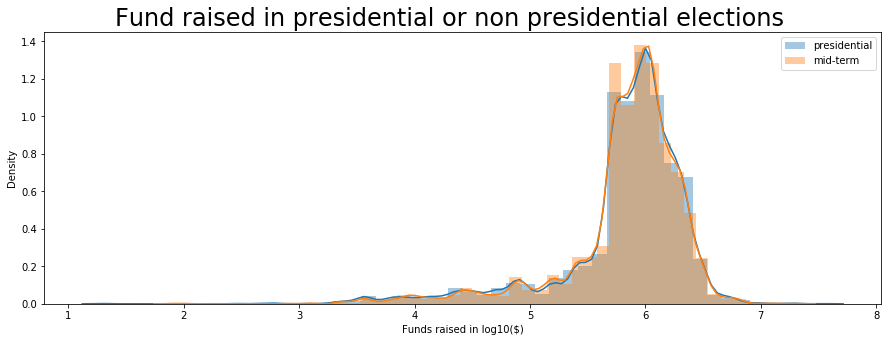

In [35]:
#fundraising
def fundraisingVsPresidentialYear(df):
    df_plt=df.dropna(subset=['fundraising', 'is_presidential_year']).copy()
    #df_plt.loc[df_plt['fundraising']<=0, 'fundraising']=1 #remove zero values
    df_plt=df_plt[df_plt['fundraising']>0]
    df_plt['fundraising']=np.log10(df_plt['fundraising']) #take the log10
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle('Fund raised in presidential or non presidential elections', fontsize=24, y=0.95)
    #print(i, year)
    sns.distplot(df_plt[df_plt['is_presidential_year']==1]['fundraising'], ax=ax, label='presidential')
    sns.distplot(df_plt[df_plt['is_presidential_year']==0]['fundraising'], ax=ax, label='mid-term')
    #set x label
    ax.set_xlabel('Funds raised in log10($)')
    #set y label
    ax.set_ylabel('Density')
    #set title
    #ax[i].set_title('year {}'.format(year))
    #set legend
    ax.legend()
fundraisingVsPresidentialYear(house_df)

In [36]:
house_df_district_count=house_df.loc[house_df['year']==2017]
house_df_district_count.groupby(['state', 'district'])['name'].first()

house_df[(house_df['state']=='California')&(house_df['district']=='District 34')&(house_df['year']==2017)]

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
9122,District 34,0.0,Robert Lee Ahn,D,40.8,California,17610.0,0,2017,0.0,0,6.8,0.0,1.0,0,0.515259,241.017241,193.724138,D,1658443.92
9126,District 34,0.0,Jimmy Gomez,D,59.2,California,25569.0,1,2017,2017.0,0,6.8,0.0,1.0,0,0.515259,241.017241,193.724138,D,1379556.75


In [37]:
#count how many observations we have for each district. 
house_df_grouped=house_df[house_df['year']!=2018].groupby(['state', 'district'])['party'].count()
house_df_grouped.reset_index(drop=False).head()

,state,district,party
0,Alabama,District 1,12
1,Alabama,District 2,16
2,Alabama,District 3,16
3,Alabama,District 4,12
4,Alabama,District 5,14


In [38]:
#wonParty=house_df[house_df['won']>0.5][['year','state', 'district', 'party']]
#wonParty=wonParty.rename(index=str, columns={"party": "wonParty"})
#house_df2=house_df.join(wonParty.set_index(['year', 'state', 'district']), on=['year', 'state', 'district'])
house_df2=house_df.copy()
house_df2['R_vs_D_Seats']=house_df2['last_R_house_seats']/(house_df2['last_R_house_seats']+house_df2['last_D_house_seats']) #1=100% R, 0=100% D
house_df2['WinLoseParty']=house_df2['party'].astype(str)+house_df2['won'].replace([0, 1], ['Loser', 'Winner'])
house_df2['won']=house_df2['won'].replace([0, 1], ['Loser', 'Winner'])
house_df2['LogFundraising']=house_df2['fundraising'].copy()
house_df2.loc[house_df2['LogFundraising']<=0, 'LogFundraising']=np.NaN
house_df2['LogFundraising']=np.log10(house_df2['LogFundraising']) #take the log10
#df['Year'].astype(str) + df['quarter']
house_df2.head()

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,...,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising,R_vs_D_Seats,WinLoseParty,LogFundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,Winner,1824,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,Winner,1826,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,Winner,1828,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,Loser,1830,1860.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DLoser,5.742661
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,Winner,1830,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661


In [39]:
#palettes for parties or other
Parties_palette=[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
             (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
             (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             (1.0, 0.4980392156862745, 0.054901960784313725),
             (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
             (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
             (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]
WinLosePalette=[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             (1.0, 0.4980392156862745, 0.054901960784313725),
             (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
             (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
             (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


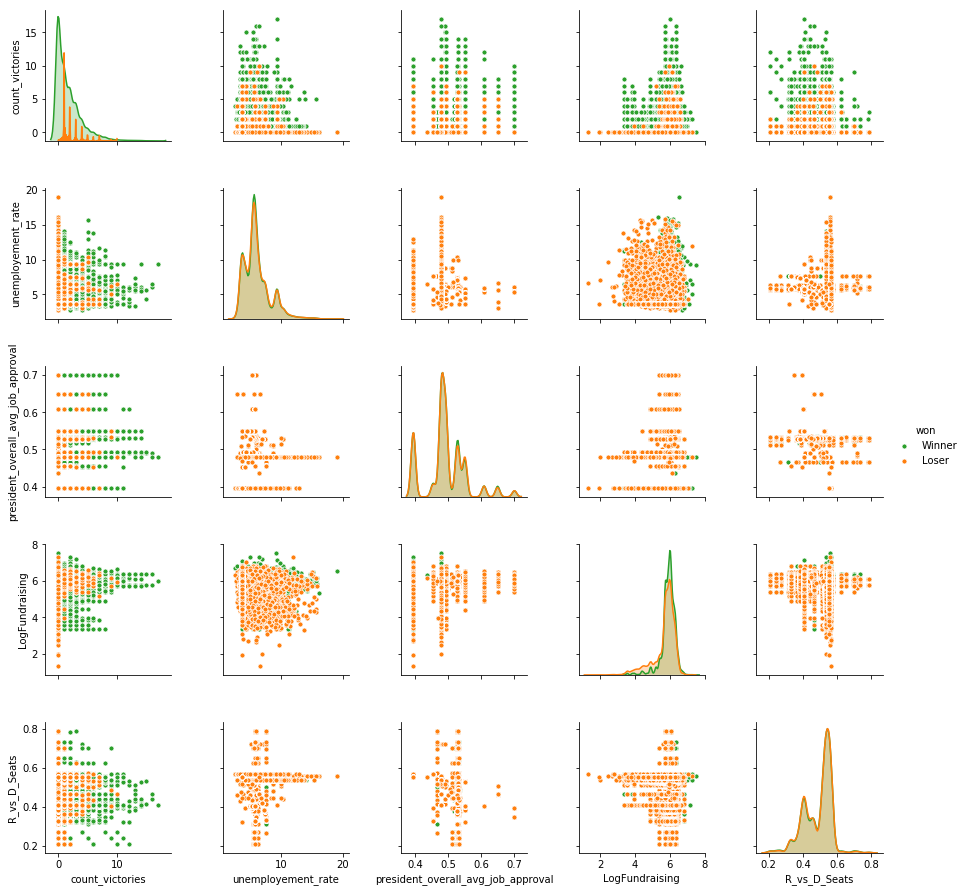

In [40]:
sns.pairplot(house_df2[[
 'party',
 'count_victories',
 'unemployement_rate',
 'president_party',
 'president_overall_avg_job_approval',
 'last_house_majority',
 'LogFundraising',
 #'WinLoseParty',
 #'wonParty',
 'R_vs_D_Seats',
 'won']], hue="won",  palette=WinLosePalette, plot_kws=dict(s=25))

In [ ]:
sns.pairplot(house_df2[house_df2['won']=='Winner'][[
 'party',
 'count_victories',
 'unemployement_rate',
 'president_party',
 'president_overall_avg_job_approval',
 'last_house_majority',
 'LogFundraising',
 #'WinLoseParty',
 #'wonParty',
 'R_vs_D_Seats',
 'won']], hue="party",  palette=Parties_palette, plot_kws=dict(s=25))

In [ ]:
#house_df2=house_df.set_index(['year', 'state', 'district', 'name']).dropna().copy()
house_df2=house_df.dropna().copy()
house_df2_districts=house_df2[['state','district']]
house_df2=house_df2.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1)
house_df2['party']=house_df2['party'].replace(['D', 'R'], [0, 1])
house_df2['president_party']=house_df2['president_party'].replace(['D', 'R'], [0, 1])
house_df2['last_house_majority']=house_df2['last_house_majority'].replace(['D', 'R'], [0, 1])

data_train, data_test=house_df2[house_df2['year']!=2018], house_df2[house_df2['year']==2018]

x_train, y_train=data_train.drop('won', axis=1), data_train['won']

x_test, y_test=data_test.drop('won', axis=1), data_test['won']
baselineLogRegr=LogisticRegressionCV(cv=5, penalty='l2').fit(x_train, y_train)

In [43]:
#Accuracy is defined as (TP+TN)/n
def printAccuracy(y_train, y_pred_train, y_test, y_pred_test):
    print('Training Set Accuracy: \t{:.2%}'.format(np.sum(y_train == y_pred_train) / len(y_train)))
    print('Test Set Accuracy: \t{:.2%}'.format(np.sum(y_test == y_pred_test) / len(y_test)))

y_pred_train=baselineLogRegr.predict(x_train)
y_pred_test=baselineLogRegr.predict(x_test)
printAccuracy(y_train, y_pred_train, y_test, y_pred_test)
print('Amount of districts in the predictions: {:.1%} of the total'.format(len(x_test.join(house_df2_districts).groupby(['state', 'district']).count())/435))

Training Set Accuracy: 	97.38%
Test Set Accuracy: 	97.02%
Amount of districts in the predictions: 100.0% of the total


In [44]:
#Baseline model 
def winnerFilter(df):
    return df[df['won']==1][['state', 'district','party']]
    
def baselineTrain(df):
    df_grouped=df[df['won']==1 ].groupby(['state', 'district', 'party'])['won'].count().reset_index(drop=False)
    df_grouped=df_grouped.groupby(['state', 'district']).agg({'won':'max',      
                                         'party': 'first'})
    return df_grouped.drop('won', axis=1).reset_index(drop=False)

In [45]:
y_pred=baselineTrain(house_df[house_df['year']!=2018]) #train simple average model, remove 2018 results
y=winnerFilter(house_df[house_df['year']==2018]) #extract winner party for each district in 2018

results=[]
for state in y['state'].unique():
    for district in y[y['state']==state]['district']:
        actual=y.loc[(y['state']==state)&(y['district']==district), 'party']
        pred=y_pred.loc[(y_pred['state']==state)&(y_pred['district']==district), 'party']
        #print('pred:{}, \nactual:{}, \npred.all():{}, \nactual.all():{}\n result:{}\n'.format(pred, actual, pred.all(), actual.all(), actual.all()==pred.all()))
        results.append(actual.all()==pred.all())
print('Test Set Accuracy: \t{:.2%}'.format(sum(results)/len(results)))

Test Set Accuracy: 	77.93%


In [46]:
def deductPartisanship(trainData, HistYears=50):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1) & (trainData['year']>=(2018-HistYears)) & (trainData['year']!=2018)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    print('In average, in the last {} years, we have data from the last {:.1f} elections in each district.\nSome districts are "new" as they exist only after a redistribution for a new congress. \nWe evaluate the partisanships of districts which exist at least since the last {:.1f} elections'.format(HistYears, avgHistData, histDataThreshold))

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(train_df, test_df):
    return test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district'])


In [ ]:
def preprocess(train_df, df):
    out_df=assignPartisanship(train_df, df).copy()
    out_df['first_time_elected']=out_df['year']-out_df['first_time_elected']
    out_df.loc[out_df['first_time_elected']<0, 'first_time_elected']=np.NaN
    out_df['Log10fundraising']=out_df['fundraising']
    out_df.loc[out_df['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    out_df['Log10fundraising']=np.log10(out_df['fundraising']) #take the log10
    return out_df[['is_incumbent',
                   'party', 
                   'first_time_elected', 
                   'count_victories', 
                   'unemployement_rate', 
                   'is_presidential_year',
                   'president_can_be_re_elected',
                   'president_party',
                   'president_overall_avg_job_approval',
                   'last_D_house_seats',
                   'last_R_house_seats',
                   'last_house_majority',
                   'fundraising',
                   'won'
                  ]]

msk=house_df['year']!=2018
data_train=preprocess(house_df[msk], house_df[msk])
data_test=preprocess(house_df[msk], house_df[~msk])

In [26]:
# table with all correlations for Republicans win
drop = ['won','votes', 'percent', 'year', 'first_time_elected', 'is_presidential_year', 'last_D_house_seats', 'last_R_house_seats','president_can_be_re_elected']
corr_df = house_df2.copy()
corr_df = corr_df.drop(drop, axis=1)
corr_df[corr_df['party'] == 1].drop('party', axis=1).corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,is_incumbent,count_victories,unemployement_rate,president_party,president_overall_avg_job_approval,last_house_majority,fundraising
is_incumbent,1.0,0.38,-0.11,0.14,-0.14,0.16,0.044
count_victories,0.38,1.0,-0.18,0.18,-0.18,-0.13,-0.02
unemployement_rate,-0.11,-0.18,1.0,-0.69,0.69,-0.44,-0.005
president_party,0.14,0.18,-0.69,1.0,-1.0,0.33,-0.00056
president_overall_avg_job_approval,-0.14,-0.18,0.69,-1.0,1.0,-0.33,0.00056
last_house_majority,0.16,-0.13,-0.44,0.33,-0.33,1.0,0.056
fundraising,0.044,-0.02,-0.005,-0.00056,0.00056,0.056,1.0


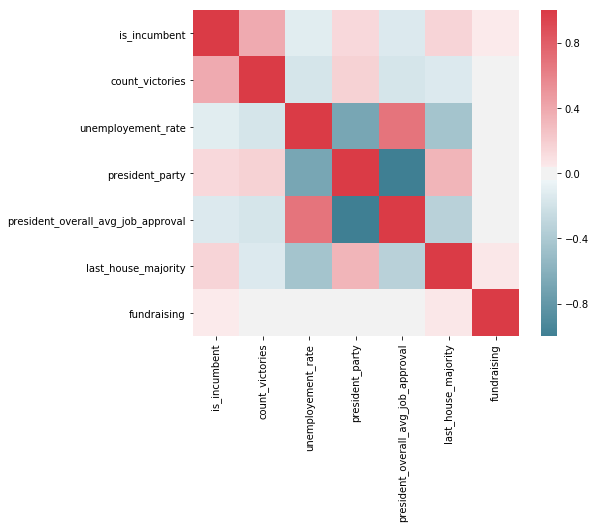

In [28]:
#heatmap is used for documentation purposes
f, ax = plt.subplots(figsize=(8, 6))
corr = corr_df[corr_df['party'] == 1].drop('party', axis=1).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [27]:
# table with all correlations for Democrats win
corr_df[corr_df['party'] == 0].drop('party',axis=1).corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,is_incumbent,count_victories,unemployement_rate,president_party,president_overall_avg_job_approval,last_house_majority,fundraising
is_incumbent,1.0,0.35,0.056,-0.037,0.037,-0.083,-0.16
count_victories,0.35,1.0,-0.093,0.081,-0.081,-0.34,-0.1
unemployement_rate,0.056,-0.093,1.0,-0.71,0.71,-0.26,-0.04
president_party,-0.037,0.081,-0.71,1.0,-1.0,0.37,-0.062
president_overall_avg_job_approval,0.037,-0.081,0.71,-1.0,1.0,-0.37,0.062
last_house_majority,-0.083,-0.34,-0.26,0.37,-0.37,1.0,-0.0096
fundraising,-0.16,-0.1,-0.04,-0.062,0.062,-0.0096,1.0


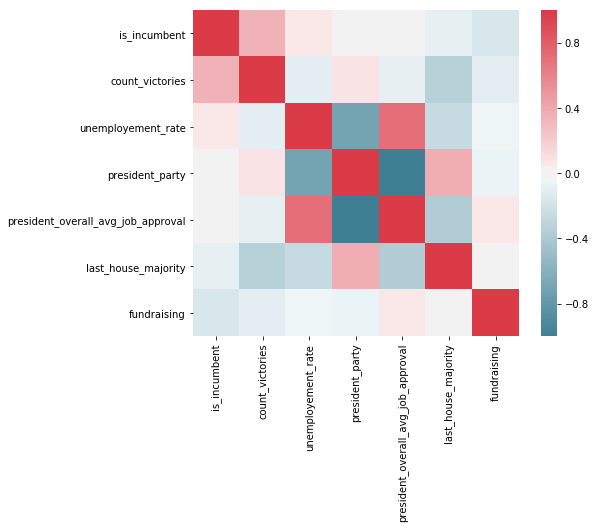

In [29]:
#heatmap is used for documentation purposes
f, ax = plt.subplots(figsize=(8, 6))
corr = corr_df[corr_df['party'] == 0].drop('party', axis=1).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [57]:
var_all = ['last_house_majority','is_incumbent', 'count_victories','unemployement_rate', 'president_overall_avg_job_approval','fundraising']

# comparison of variables with boxplots
def expl_boxplots(dataframe,variables):
    house_df2_D = dataframe[dataframe['party'] == 0]
    house_df2_R = dataframe[dataframe['party'] == 1]
    fig = plt.figure(figsize=(10,6))
    for i in range(len(var_all)):
        plt.subplot(2,3,i+1)
        a = pd.DataFrame({ 'group' : np.repeat('Democrat',house_df2_D.shape[0]), 'value': house_df2_D[var_all[i]] })
        b = pd.DataFrame({ 'group' : np.repeat('Republican',house_df2_R.shape[0]), 'value': house_df2_R[var_all[i]] })
        plt.title(var_all[i])
        df=a.append(b)
        # Usual boxplot
        sns.boxplot(x='group', y='value', data=df)
    fig
    plt.tight_layout()

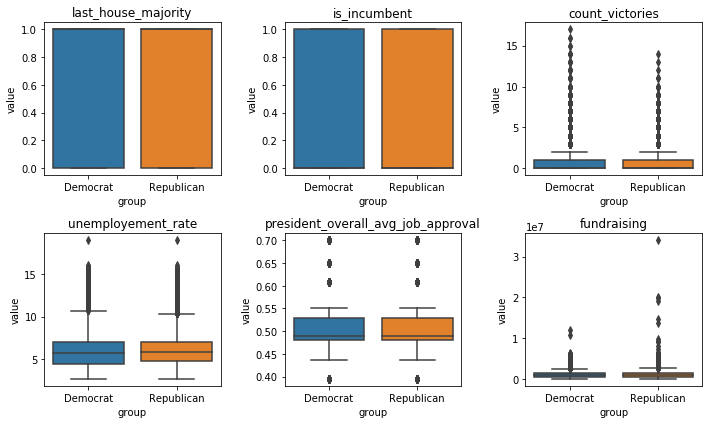

In [56]:
expl_boxplots(house_df2,var_all)

# Variable selection